<a href="https://colab.research.google.com/github/npasuparthi/nagendra-AI_ML/blob/master/Copy_of_FlowerImageClassification_TransferLearning_NP_PGAIML_Mar20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tflearn

     |████████████████████████████████| 112kB 8.3MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127300 sha256=54b82ef21b57696fec4f4082ad8aa654d727fbbc9f83eb7cb72de23904908750
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [2]:
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
import tensorflow as tf

In [4]:
X, Y = oxflower17.load_data()

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [5]:
#(2) Analyze dimensions - there are 1360 examples, each example is a 224x224 RGB Image
X.shape


(1360, 224, 224, 3)

In [6]:
# (3) Display the Labels
Y


array([13,  7,  9, ...,  2,  9, 12])

In [7]:
# Display unique types - there are 17 different types of flowers
import numpy as np
print(np.unique(Y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [8]:
# (3) Display the Images along with class code (appears above the Image)
%matplotlib inline

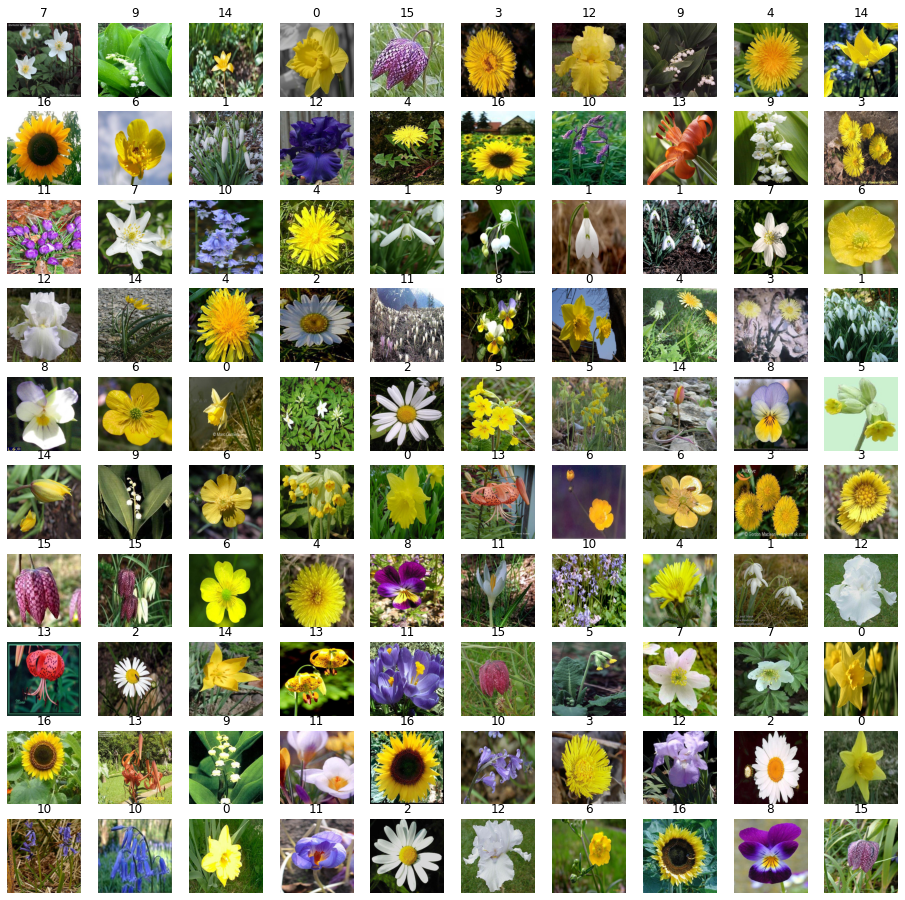

In [9]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16, 16))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(Y[i])
    plt.axis("off")
plt.show()


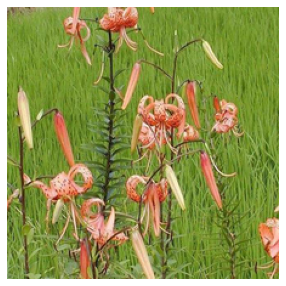

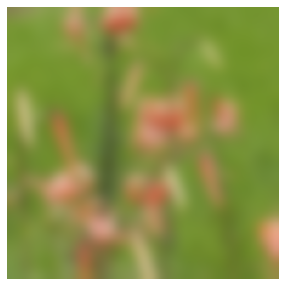

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


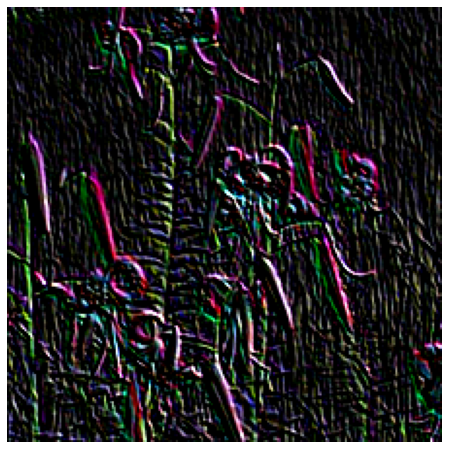

In [10]:
import cv2

# Original Image
plt.figure(figsize=(5,5))
plt.imshow(X[0])
plt.axis("off")
plt.show()

# Gaussian Blur
Blur_Effect_Img = cv2.GaussianBlur(X[0], (35, 35), 0)
plt.figure(figsize=(5,5))
plt.imshow(Blur_Effect_Img,cmap="gray")
plt.axis("off")
plt.show()

#Emboss filter
Emboss_Kernel = np.array([[0,-1,-1],[1,0,-1],[1,1,0]])
Emboss_Effect_Img = cv2.filter2D(src=X[0], kernel=Emboss_Kernel, ddepth=-1)
plt.figure(figsize=(8,8))
plt.imshow(Emboss_Effect_Img,cmap="gray")
plt.axis("off")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=24)

In [12]:
#Encoding the output class label (One-Hot Encoding)
from keras.utils import np_utils
trainY=np_utils.to_categorical(y_train,17)
testY=np_utils.to_categorical(y_test,17)

In [14]:
# use Inceptionv3 to build a classifier

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import regularizers


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-3))(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(17, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(X_train, trainY ,batch_size=128, epochs=5,verbose=1,validation_data=(X_test, testY))

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from tensorflow.keras.optimizers import adam
adamOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(adamOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(X_train, trainY ,batch_size=128, epochs=50,verbose=1,validation_data=(X_test, testY))

Train on 911 samples, validate on 449 samples
Epoch 1/5
911/911 [==============================] - ETA: 0s - loss: 2.6654 - acc: 0.2382

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


911/911 [==============================] - 5s 6ms/sample - loss: 2.6654 - acc: 0.2382 - val_loss: 2.7954 - val_acc: 0.2227
Epoch 2/5
911/911 [==============================] - 3s 3ms/sample - loss: 1.8006 - acc: 0.5928 - val_loss: 2.9590 - val_acc: 0.2829
Epoch 3/5
911/911 [==============================] - 3s 4ms/sample - loss: 1.2739 - acc: 0.7442 - val_loss: 3.2664 - val_acc: 0.2962
Epoch 4/5
911/911 [==============================] - 3s 4ms/sample - loss: 0.9321 - acc: 0.8529 - val_loss: 2.8581 - val_acc: 0.3898
Epoch 5/5
911/911 [==============================] - 3s 4ms/sample - loss: 0.7502 - acc: 0.8825 - val_loss: 3.2365 - val_acc: 0.3274
0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_nor

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=57)

In [60]:
# Data Normalization
X_train/=255
X_test/=255

In [61]:
#Encoding the output class label (One-Hot Encoding)
from keras.utils import np_utils
trainY=np_utils.to_categorical(y_train,17)
testY=np_utils.to_categorical(y_test,17)

In [62]:

# (4) build a simpe CNN model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(tf.keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(tf.keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(17, activation = "softmax"))

In [68]:
adamOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(adamOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])			 

In [69]:
history = model.fit(X_train, trainY ,batch_size=128, epochs=50,verbose=1,validation_data=(X_test, testY))

Train on 911 samples, validate on 449 samples
Epoch 1/50
896/911 [============================>.] - ETA: 0s - loss: 2.8407 - acc: 0.0536

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


911/911 [==============================] - 3s 3ms/sample - loss: 2.8409 - acc: 0.0538 - val_loss: 2.8357 - val_acc: 0.0468
Epoch 2/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8377 - acc: 0.0615 - val_loss: 2.8363 - val_acc: 0.0468
Epoch 3/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8331 - acc: 0.0648 - val_loss: 2.8385 - val_acc: 0.0468
Epoch 4/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8332 - acc: 0.0637 - val_loss: 2.8426 - val_acc: 0.0468
Epoch 5/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8334 - acc: 0.0648 - val_loss: 2.8447 - val_acc: 0.0468
Epoch 6/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8327 - acc: 0.0648 - val_loss: 2.8429 - val_acc: 0.0468
Epoch 7/50
911/911 [==============================] - 2s 2ms/sample - loss: 2.8321 - acc: 0.0648 - val_loss: 2.8436 - val_acc: 0.0468
Epoch 8/50
911/911 [==============================] - 2s 2ms/sample - los

In [ ]:
# Question 5
# simple CNN model is unable to learn due to lmited depth as teh number of inputs features 224x224x3 is huge compared to the model parameters and thus gorssly underfit
